# Week 5

## Exercice 1: Build the right graph for visualization:

>1. Use NetworkX `DiGraph` to store the network of rappers. Remember that rappers are linked if they have a corresponding link between their Wiki contents.
>   * **Additionally**, extract the largest component - it will make our work with visualizations much easier (note: removing *isolated* nodes (with no links) does not guarantee that you are left with the largest component).
>     - *Note 1*: You probably have the right graph if you have around 730 nodes and 6000 edges.
>     - *Note 2*: For directed graphs use `weakly connected component` to extract the largest component.
>     - *Note 3*: Further analysis is done with the largest component

In [17]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import requests
import re

In [18]:
# Read the csv file with the rapper names in the west and east coast
EastCoastRappers = pd.read_csv("../files/EastCoastRappers.csv")
WestCoastRappers = pd.read_csv("../files/WestCoastRappers.csv")
BothCoastRappers = pd.read_csv("../files/BothCoastRappers.csv")

def build_rappers_network():

    G = nx.DiGraph()
    
    # Add nodes to the graph
    for index, row in EastCoastRappers.iterrows():
        G.add_node(row['WikipediaPageName'], region='EastCoast')

    for index, row in WestCoastRappers.iterrows():
        G.add_node(row['WikipediaPageName'], region='WestCoast')

    for index, row in BothCoastRappers.iterrows():
        G.add_node(row['WikipediaPageName'], region='BothCoast')

    # Setup wikipedia requests
    WIKI_REQUEST_URL = "https://en.wikipedia.org/w/api.php?"
    params = {
        'action': 'query',
        'format': 'json',
        'prop': 'links',
        'pllimit': 'max',
        'titles': ''
    }

    # Add edges to the graph 
    # It should have an edge between two rappers if their wikipedia pages link to each other
    for index, row in EastCoastRappers.iterrows():
        params['titles'] = row['WikipediaPageName']
        request = requests.get(WIKI_REQUEST_URL, params=params).json().get('query').get('pages').popitem()[1].get('links')
        for link in request:
            if (link['title'] in G.nodes()):
                G.add_edge(row['WikipediaPageName'], link['title'])

    for index, row in WestCoastRappers.iterrows():
        params['titles'] = row['WikipediaPageName']
        request = requests.get(WIKI_REQUEST_URL, params=params).json().get('query').get('pages').popitem()[1].get('links')
        for link in request:
            if (link['title'] in G.nodes()):
                G.add_edge(row['WikipediaPageName'], link['title'])

    for index, row in BothCoastRappers.iterrows():
        params['titles'] = row['WikipediaPageName']
        request = requests.get(WIKI_REQUEST_URL, params=params).json().get('query').get('pages').popitem()[1].get('links')
        for link in request:
            if (link['title'] in G.nodes()):
                G.add_edge(row['WikipediaPageName'], link['title'])
    
    return G

In [19]:
graph = build_rappers_network()

In [20]:
largest_component = max(nx.weakly_connected_components(graph), key=len)
graph = graph.subgraph(largest_component)

In [21]:
nb_nodes = graph.number_of_nodes()
nb_edges = graph.number_of_edges()

print("Number of nodes: ", nb_nodes)
print("Number of edges: ", nb_edges)


Number of nodes:  729
Number of edges:  5909


>2. As you build the graph, store the attributes of the nodes (their `coast`). On top of that, let's also store the `length of the content` as one of the attributes of the node (i.e. count the number of *words* you have in each rapper's page). By storing this information as nodal features, we keep all the relevant data in one place. The safe way to count words without counting symbols is to use `regex`, but simpler methods are OK.

In [22]:
# For all rapers, add the number of words contained in their wikipedia page to the graph
# Use regex to count the number of words

# Setup wikipedia requests
WIKI_REQUEST_URL = "https://en.wikipedia.org/w/api.php?"
params = {
    'action': 'query',
    'format': 'json',
    'prop': 'extracts',
    'explaintext': True,
    'titles': ''
}

for node in graph.nodes():
    params['titles'] = node
    request = requests.get(WIKI_REQUEST_URL, params=params).json().get('query').get('pages').popitem()[1].get('extract')
    nb_words = len(re.findall(r'\w+', request))
    graph.nodes[node]['nb_words'] = nb_words

## Exercise 2: Let's build a simple visualization of the network

>1. For the sake of the visualisation, let's convert our network to *undirected graph* (tip: There is a NetworkX command to help you).
>   * *Note*: Keep the directed graph, we will use it in couple of the following exercises

In [23]:
undirected_graph = graph.to_undirected()

>2. Use the NetworkX command `nx.draw_kamada_kawai` to draw the resulting undirected network. (You can find [background on the algorithm here](https://en.wikipedia.org/wiki/Force-directed_graph_drawing).)  
>   * Node color should depend on the `coast` attribute (i.e. use different colors for west-coast and east-coast rappers).
>   * Set up your plot so that node-size depends on the node *degree*
>   * **Optional**: Set up you plot so that edge color depends on the `role` attribute. If an edge connects west-coast rappers, assign `color_a`, if the edge connects east-coast rappers assign `color_b`, in other cases assign `color_c` (i.e. when rapper from different coasts are connected). (Here, you get to decide on the colors.)

In [24]:
# Add role attribut to each edge
# If the edge is between two rappers from the east coast, the role is 'east'
# If the edge is between two rappers from the west coasts, the role is 'west'
# If the edge is between two rappers from a different coast, the role is 'crossing'
for edge in undirected_graph.edges():
    if (undirected_graph.nodes[edge[0]]['region'] == undirected_graph.nodes[edge[1]]['region']):
        undirected_graph.edges[edge]['role'] = undirected_graph.nodes[edge[0]]['region']
    else:
        undirected_graph.edges[edge]['role'] = 'crossing'

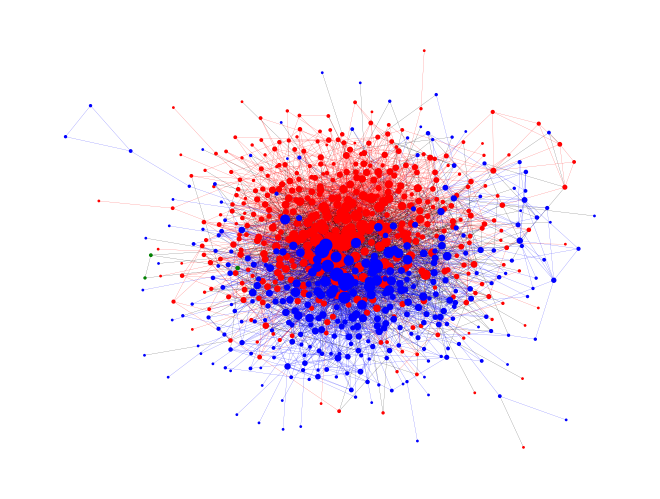

In [25]:
# Node colors based on the region
node_colors = []
for node in undirected_graph.nodes():
    if (undirected_graph.nodes[node]['region'] == 'EastCoast'):
        node_colors.append('red')
    elif (undirected_graph.nodes[node]['region'] == 'WestCoast'):
        node_colors.append('blue')
    else:
        node_colors.append('green')

# Node size depends on the node degree
node_sizes = []
for node in undirected_graph.nodes():
    node_sizes.append(undirected_graph.degree[node])

# Edges color depends on the type of the edge
# If the edge is between two rappers from the east coast, the color is blue
# If the edge is between two rappers from the west coasts, the color is red
# If the edge is between two rappers from a different coast, the color is black
edge_colors = []
for edge in undirected_graph.edges():
    if (undirected_graph.edges[edge]['role'] == 'WestCoast'):
        edge_colors.append('blue')
    elif (undirected_graph.edges[edge]['role'] == 'EastCoast'):
        edge_colors.append('red')
    else:
        edge_colors.append('black')

nx.draw_kamada_kawai(undirected_graph, node_color=node_colors, node_size=node_sizes, width=0.1, with_labels=False, edge_color=edge_colors)

## Exercise 3: From the previous plot it is more difficult to observe any specific structure in the network. We can make even better visualisations with `ForceAtlas2` package:

>2.You can install the  package typing `pip install fa2` in the terminal. The [github page](https://github.com/bhargavchippada/forceatlas2) explains how to use the package to get coordinates for each node.
>   * (**Hint**: if you install force atlas and Python can't find the package it might be because you computer tries to use the system's `pip`, therefore, try installing using the Anaconda pip explicitly ( on mac you would use `~/anaconda2/bin/pip install fa2`).
> * Visualize the network using the [Networkx draw function](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw), and node-coordinates from the force atlas algorithm. As in the previous Exercise:
>   * Node color should depend on the `coast` attribute (i.e. use different colors for west-coast and east-coast rappers)
>   * Node size should depend on the node *degree*
>   * **Optional**: edge color should depend on the `coast` attribute. If an edge connects west-coast rappers, assign `color_a`, if the edge connects east-coast rappers from  assign `color_b`, in other cases assign `color_c` (i.e. when connected rappers are from different coasts).
> * Play with the force atlas algorithm parameters to obtain a visualization you like. It may look similar to the one below (but not necessarily). 
> * Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes? Do you see any interesting group of nodes (can you guess who's involved)?

Impossible to download this library

## Exercise 4: We continue with a qualitative inspection of the rapper Wiki pages, that will help us to intepret our results. We investigate the reasons for links between rappers to exist on rapper Wiki.

>1. Consider the top 3 nodes with highest in-degree in the network. Open the corresponding Wiki pages.
>   * Consider the set of neighbours pointing towards the node found above. Look for them in the page. 
>   * What is the relation between the rappers you identified and his/her network neighbours? (e.g., do they come from the same coast, did they write songs together, etc.). You don't need to come up with a grand theory of rap music here, I just want you to think about how links come about.
>   * Repeat the exercise for the top 3 out-degree node. 
>   * Are there differences between reasons for out- and in-links? Again, there's no right answer here. I just want you to think about some of the reasons why links may occur between rappers.

In [26]:
# Top three nodes with the highest in-degree

# Sort the nodes by in-degree
in_degree = sorted(graph.in_degree, key=lambda x: x[1], reverse=True)

# Print the top three nodes with the highest in-degree
print("Top three nodes with the highest in-degree: ")
for i in range(3):
    print(in_degree[i])

# Get the set of neighbours to the top three nodes with the highest in-degree
in_degree_nodes = set()
for i in range(3):
    in_degree_nodes = in_degree_nodes.union(set(graph.predecessors(in_degree[i][0])))

# Print that set
print("Set of nodes pointing to the top three nodes with the highest in-degree: ")
print(in_degree_nodes)


Top three nodes with the highest in-degree: 
('Jay-Z', 124)
('Snoop Dogg', 119)
('50 Cent', 100)
Set of nodes pointing to the top three nodes with the highest in-degree: 
{'The Game (rapper)', 'Young M.A', 'Fabolous', 'Black Thought', 'Lil Skies', 'Ice-T', 'DJ Quik', 'Swizz Beatz', 'Sonaro', 'Jahlil Beats', 'JT the Bigga Figga', 'CJ Mac', 'Wyldfyer', 'Kurupt', 'RJ (rapper)', 'O.T. Genasis', 'Don Cannon', 'Call Me Ace', 'Casey Veggies', 'Hi-C (rapper)', 'Dr. Dre', 'Method Man', 'Mann (rapper)', 'N.O.R.E.', 'Hit-Boy', 'Slim the Mobster', 'Syd (singer)', 'MC Lyte', 'TeeFlii', 'Joey Fatts', 'Roscoe (rapper)', 'DJ Khalil', 'Shyne', 'Jipsta', 'The Notorious B.I.G.', 'Ty Fyffe', 'Fat Joe', 'MC Lars', 'Cardi B', 'Frenchie (rapper)', 'Saigon (rapper)', 'Scoop DeVille', 'The Alchemist (musician)', 'Lloyd Banks', 'Kool G Rap', 'Danger Mouse (musician)', 'Scar Lip', 'Kam (rapper)', 'Bishop Nehru', 'Prodigy (rapper)', 'Rah Swish', 'Fetty Wap', 'Mike Shinoda', 'Bizzle', 'Mix Master Mike', 'ASAP Twel

In [31]:
# Top three nodes with the highest out-degree

# Sort the nodes by out-degree
out_degree = sorted(graph.out_degree, key=lambda x: x[1], reverse=True)

# Print the top three nodes with the highest out-degree
print("Top three nodes with the highest out-degree: ")
for i in range(3):
    print(out_degree[i])
    # Get the number of in-edges for each node
    print("Number of in-edges: ", len(graph.in_edges(out_degree[i][0])))

# Get the set of neighbours to the top three nodes with the highest out-degree
out_degree_nodes = set()
for i in range(3):
    out_degree_nodes = out_degree_nodes.union(set(graph.successors(out_degree[i][0])))

# Print that set
print("Set of nodes pointed by the top three nodes with the highest out-degree: ")
print(out_degree_nodes)


Top three nodes with the highest out-degree: 
('Drag-On', 53)
Number of in-edges:  6
('Black Thought', 43)
Number of in-edges:  21
('DJ Dahi', 38)
Number of in-edges:  4
Set of nodes pointed by the top three nodes with the highest out-degree: 
{'Cardiak', 'Young Noble', 'Ab-Soul', 'Jay Rock', 'Kendrick Lamar', 'Melle Mel', 'Apathy (rapper)', 'Inspectah Deck', 'Mach-Hommy', 'Fred the Godson', 'Mistah F.A.B.', 'ASAP Rocky', 'Cory Gunz', 'Black Thought', 'Dave East', 'Grandmaster Caz', 'Thurz', 'Ice-T', 'Conway the Machine', 'Bodega Bamz', 'Swizz Beatz', 'Vado (rapper)', 'Uncle Murda', 'Jake One', 'Remy Ma', 'Mos Def', 'Schoolboy Q', "Lil' Cease", 'Focus...', 'Problem (rapper)', 'Neo da Matrix', 'Funkmaster Flex', 'Terrace Martin', 'Pharoahe Monch', 'J.R. Writer', 'Nas', 'Del the Funky Homosapien', 'YG (rapper)', 'Beanie Sigel', 'G Koop', 'Kurupt', 'Warren G', 'AZ (rapper)', 'Glasses Malone', 'DJ Kay Slay', 'Eve (rapper)', 'El-P', 'Jay-Z', 'Curtiss King', 'Casey Veggies', 'Malik B.', 'Dr.

>2. Are there any nodes with high out-degree and with few incoming connections? If yes, open the Wiki pages of such rappers and explain what happens?

>3. Are there any nodes with high in-degree and few outcoming connections? Again, open the Wiki pages of such rappers and explain what happens? 

>4. Do any nodes have particularly many links to rappers from the opposite coast? If yes, try and find out what is going on.